In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Optional

# Project root 
PROJECT_ROOT = Path(r"C:/Users/A/Desktop/MSc CLS/SVVR/project")
VIZ_CALCIUM_DIR = PROJECT_ROOT / "viz-calcium"
VIZ_STIMULUS_DIR = PROJECT_ROOT / "viz-stimulus"
POS_FILE = VIZ_CALCIUM_DIR / "positions" / "rank_0_positions.txt"
MONITOR_DIR = VIZ_STIMULUS_DIR / "monitors"

MAX_NEURONS = 2000     # smaller for temporal analysis
MAX_STEPS = 200000     # enough to observe convergence


def load_positions(positions_file: str, max_neurons: Optional[int] = None):
    """
    Load neuron positions from file.
    Format: <nid+1> <x> <y> <z> <area> "ex"
    """
    positions = {}
    areas = {}
    
    with open(positions_file) as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("#"):
                continue
            parts = line.split()
            
            # Need at least 5 parts: nid, x, y, z, area (6th is "ex")
            if len(parts) < 5:
                continue
            
            try:
                nid = int(parts[0]) - 1  # Convert to zero-based
                x, y, z = map(float, parts[1:4])
                area = parts[4]
                
                positions[nid] = (x, y, z)
                areas[nid] = area
            except (ValueError, IndexError) as e:
                # Skip malformed lines
                continue
    
    all_ids_sorted = sorted(positions.keys())
    subset_ids = all_ids_sorted[:max_neurons] if max_neurons else all_ids_sorted
    
    return positions, areas, subset_ids


# Load positions
positions, areas, subset_ids = load_positions(str(POS_FILE), MAX_NEURONS)
print(f"Loaded {len(subset_ids)} neurons.")
print(f"Example neuron IDs: {subset_ids[:5]}")
print(f"Example positions: {[positions[nid] for nid in subset_ids[:3]]}")



Loaded 2000 neurons.
Example neuron IDs: [0, 1, 2, 3, 4]
Example positions: [(88.017654, 143.88911, 83.259131), (88.071787, 143.7922, 83.237149), (88.093434, 143.9519, 83.168331)]


In [5]:
def load_calcium_series(monitor_dir: str, subset_ids, max_steps=None):
    calcium_data = {}

    for nid in subset_ids:
        path = Path(monitor_dir) / f"0_{nid}.csv"
        if not path.exists():
            continue

        df = pd.read_csv(path, sep=";", header=None, nrows=max_steps)
        try:
            calcium_data[nid] = df.iloc[:, 5].astype(float).to_numpy()
        except Exception:
            continue

    return calcium_data

calcium_data = load_calcium_series(
    monitor_dir=str(MONITOR_DIR),
    subset_ids=subset_ids,
    max_steps=MAX_STEPS,
)

print(f"Loaded calcium traces for {len(calcium_data)} neurons.")



Loaded calcium traces for 1264 neurons.


#### We visualize individual calcium trajectories:

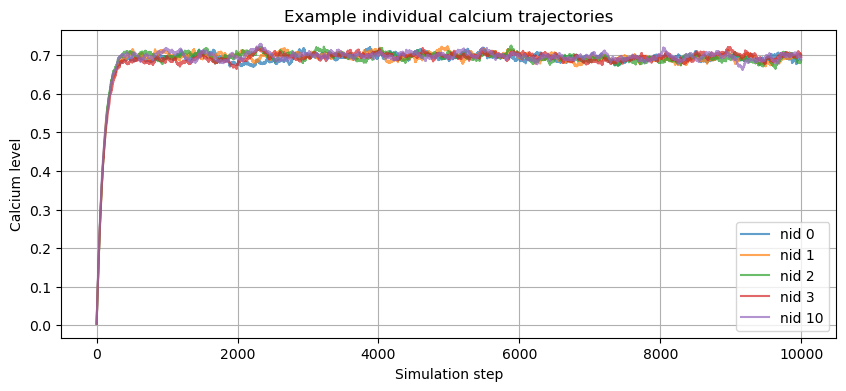

In [32]:
example_nids = list(calcium_data.keys())[:5]

plt.figure(figsize=(10, 4))
for nid in example_nids:
    plt.plot(calcium_data[nid], alpha=0.7, label=f"nid {nid}")

plt.xlabel("Simulation step")
plt.ylabel("Calcium level")
plt.title("Example individual calcium trajectories")
plt.legend()
plt.grid(True)
plt.show()

#### Neuron-population average of calcium over time

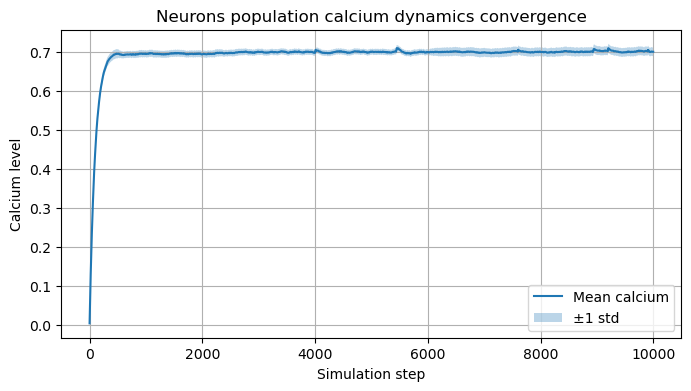

In [33]:
min_len = min(len(v) for v in calcium_data.values())
calcium_matrix = np.vstack([v[:min_len] for v in calcium_data.values()])

mean_over_time = calcium_matrix.mean(axis=0)
std_over_time = calcium_matrix.std(axis=0)

plt.figure(figsize=(8, 4))
plt.plot(mean_over_time, label="Mean calcium")
plt.fill_between(
    np.arange(min_len),
    mean_over_time - std_over_time,
    mean_over_time + std_over_time,
    alpha=0.3,
    label="±1 std"
)
plt.xlabel("Simulation step")
plt.ylabel("Calcium level")
plt.title("Neurons population calcium dynamics convergence")
plt.legend()
plt.grid(True)
plt.show()

### Initial phase (transient) vs steady-state regime
Steady-state window = last $30\%$ of the simulation time series

Steady-state starts at step index: 7000


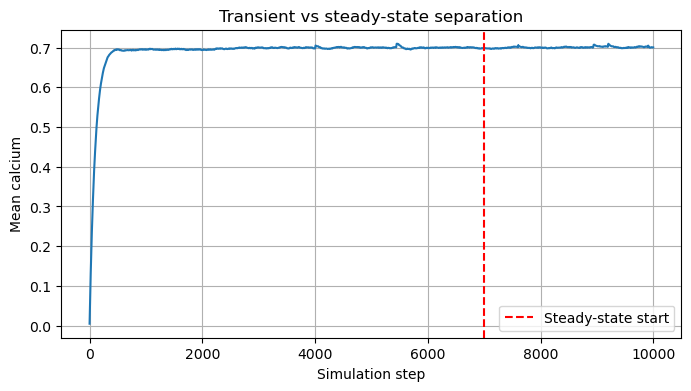

In [17]:
steady_start = int(0.7 * min_len)
print("Steady-state starts at step index:", steady_start)

plt.figure(figsize=(8, 4))
plt.plot(mean_over_time)
plt.axvline(steady_start, color="red", linestyle="--", label="Steady-state start")
plt.xlabel("Simulation step")
plt.ylabel("Mean calcium")
plt.title("Transient vs steady-state separation")
plt.legend()
plt.grid(True)
plt.show()


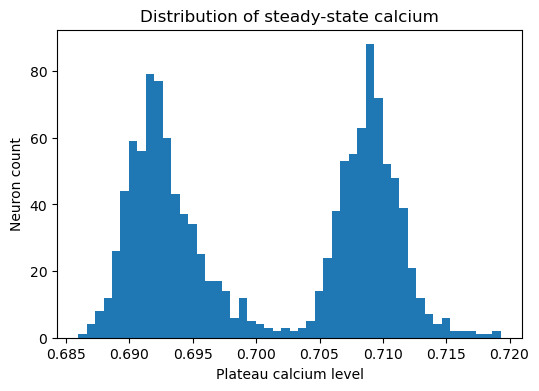

In [18]:
# also as option justification we can visualize per-neuron calcium plateau:

plateau_calcium = {
    nid: np.median(trace[steady_start:])
    for nid, trace in calcium_data.items()
}

plt.figure(figsize=(6, 4))
plt.hist(list(plateau_calcium.values()), bins=50)
plt.xlabel("Plateau calcium level")
plt.ylabel("Neuron count")
plt.title("Distribution of steady-state calcium")
plt.show()


### Calcium convergence:


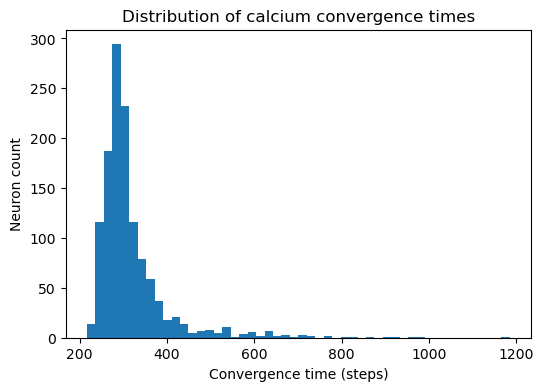

Convergence statistics:
Median convergence time: 296.0
90th percentile: 395.70000000000005
Non-converged neurons: 0


In [19]:
def estimate_convergence_time(trace, plateau, eps_frac=0.05, min_duration=200):
    eps = eps_frac * plateau
    for t in range(len(trace) - min_duration):
        window = trace[t:t + min_duration]
        if np.all(np.abs(window - plateau) <= eps):
            return t
    return np.nan

convergence_times = {}

for nid, trace in calcium_data.items():
    plateau = plateau_calcium[nid]
    convergence_times[nid] = estimate_convergence_time(trace, plateau)

conv_vals = np.array([v for v in convergence_times.values() if not np.isnan(v)])

plt.figure(figsize=(6, 4))
plt.hist(conv_vals, bins=50)
plt.xlabel("Convergence time (steps)")
plt.ylabel("Neuron count")
plt.title("Distribution of calcium convergence times")
plt.show()

print("Convergence statistics:")
print("Median convergence time:", np.nanmedian(conv_vals))
print("90th percentile:", np.nanpercentile(conv_vals, 90))
print("Non-converged neurons:", np.isnan(list(convergence_times.values())).sum())


Key findings for RQ1:

(i) Neuronal calcium exhibits a pronounced transient phase followed by stabilization;

(ii) Convergence times vary substantially across neurons;

(iii) A steady-state regime can be robustly identified earlier than designated $70\%$ of the simulation;

(iv) Plateau calcium values provide a meaningful static abstraction for spatial visualization before we make 3D visualizations and animations;


(v) Early simulation steps should be excluded from 3D calcium visualizations.